In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
import math
import json
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential

In [ ]:
!pip install pydub
!pip install noisereduce
!pip install json-tricks

In [ ]:
!pip install resampy

In [ ]:
X.shape

In [ ]:
from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = 'model_main.json'
saved_weights_path = 'model_main.weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)
    
model.save_weights(saved_weights_path)
print("Saved model to disk")

In [ ]:
saved_model_path = '/kaggle/working/model_main.json'
saved_weights_path = '/kaggle/working/best_model1.weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()
    
# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='sparse_categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
emotions = {
    0 : 'neutral',
    1 : 'calm',
    2 : 'happy',
    3 : 'sad',
    4 : 'angry',
    5 : 'fearful',
    6 : 'disgust',
    7 : 'suprised'   
}
emo_list = list(emotions.values())

def is_silent(data):
    # Returns 'True' if below the 'silent' threshold
    return max(data) < 100

In [ ]:
import pyaudio
import wave
from array import array
import struct
import time

# Initialize variables
RATE = 24414
CHUNK = 512
RECORD_SECONDS = 7.1

FORMAT = pyaudio.paInt32
CHANNELS = 1
WAVE_OUTPUT_FILE = "/kaggle/input/manual-testing/my_recoo (7).wav"

# Open an input channel
p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)


# Initialize a non-silent signals array to state "True" in the first 'while' iteration.
data = array('h', np.random.randint(size = 512, low = 0, high = 500))

# SESSION START
print("** session started")
total_predictions = [] # A list for all predictions in the session.
tic = time.perf_counter()

while is_silent(data) == False:
    print("* recording...")
    frames = [] 
    data = np.nan # Reset 'data' variable.

    timesteps = int(RATE / CHUNK * RECORD_SECONDS) # => 339

    # Insert frames to 'output.wav'.
    for i in range(0, timesteps):
        data = array('l', stream.read(CHUNK)) 
        frames.append(data)

        wf = wave.open(WAVE_OUTPUT_FILE, 'wb')
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))

    print("* done recording")

    x = preprocess(WAVE_OUTPUT_FILE) # 'output.wav' file preprocessing.
    # Model's prediction => an 8 emotion probabilities array.
    predictions = model.predict(x)
    pred_list = list(predictions)
    pred_np = np.squeeze(np.array(pred_list).tolist(), axis=0) # Get rid of 'array' & 'dtype' statments.
    total_predictions.append(pred_np)
    
    # Present emotion distribution for a sequence (7.1 secs).
    fig = plt.figure(figsize = (10, 2))
    plt.bar(emo_list, pred_np, color = 'darkturquoise')
    plt.ylabel("Probabilty (%)")
    plt.show()
    
    max_emo = np.argmax(predictions)
    print('max emotion:', emotions.get(max_emo,-1))
    
    print(100*'-')
    
    # Define the last 2 seconds sequence.
    last_frames = np.array(struct.unpack(str(96 * CHUNK) + 'B' , np.stack(( frames[-1], frames[-2], frames[-3], frames[-4],
                                                                            frames[-5], frames[-6], frames[-7], frames[-8],
                                                                            frames[-9], frames[-10], frames[-11], frames[-12],
                                                                            frames[-13], frames[-14], frames[-15], frames[-16],
                                                                            frames[-17], frames[-18], frames[-19], frames[-20],
                                                                            frames[-21], frames[-22], frames[-23], frames[-24]),
                                                                            axis =0)) , dtype = 'b')
    if is_silent(last_frames): # If the last 2 seconds are silent, end the session.
        break

# SESSION END        
toc = time.perf_counter()
stream.stop_stream()
stream.close()
p.terminate()
wf.close()
print('** session ended')

# Present emotion distribution for the whole session.
total_predictions_np =  np.mean(np.array(total_predictions).tolist(), axis=0)
fig = plt.figure(figsize = (10, 5))
plt.bar(emo_list, total_predictions_np, color = 'indigo')
plt.ylabel("Mean probabilty (%)")
plt.title("Session Summary")
plt.show()

print(f"Emotions analyzed for: {(toc - tic):0.4f} seconds")

In [ ]:
import os
import json
import librosa
import numpy as np
import re
import resampy

# Define the emotion mappings for each dataset
emotion_mapping_ravdess = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

emotion_mapping_crema = {
    "SAD": "sad",
    "ANG": "angry",
    "DIS": "disgust",
    "FEA": "fearful",
    "HAP": "happy",
    "NEU": "neutral"
}

emotion_mapping_tess = {
    "ps": "surprised",
    "disgust": "disgust",
    "fear": "fearful",
    "happy": "happy",
    "neutral": "neutral",
    "sad": "sad",
    "angry": "angry"
}

emotion_mapping_savee = {
    "a": "angry",
    "d": "disgust",
    "f": "fearful",
    "h": "happy",
    "n": "neutral",
    "sa": "sad",
    "su": "surprised"
}

# Label mapping (same across datasets)
label_mapping = {
    "neutral": 0,
    "happy": 1,
    "sad": 2,
    "angry": 3,
    "fearful": 4,
    "disgust": 5,
    "surprised": 6
}

# Function to extract emotion label
def extract_emotion_label(filename, dataset_name):
    if dataset_name == "Ravdess":
        components = filename.split("-")
        emotion_code = components[2]
        emotion = emotion_mapping_ravdess.get(emotion_code, "unknown")
    elif dataset_name == "Crema":
        emotion_code = filename.split("_")[2]
        emotion = emotion_mapping_crema.get(emotion_code, "unknown")
    elif dataset_name == "Tess":
        emotion_code = filename.split("_")[-1].replace(".wav", "")
        emotion = emotion_mapping_tess.get(emotion_code, "unknown")
    elif dataset_name == "Savee":
        parts = filename.split('_')
        if len(parts) > 1:
            extracted_part = parts[1]
            emotion_code = re.match(r"[a-zA-Z]+", extracted_part).group()
            emotion = emotion_mapping_savee.get(emotion_code, "unknown")
        else:
            emotion = "unknown"
    else:
        emotion = "unknown"
    return emotion, label_mapping.get(emotion, -1)

# # Data augmentation functions
# def augment_audio(audio, sr):
#     augments = []
    
#     # Original
#     augments.append(audio)
    
#     # Add noise
#     noise_amp = 0.035 * np.random.uniform() * np.amax(audio)
#     audio_noise = audio + noise_amp * np.random.normal(size=audio.shape[0])
#     augments.append(audio_noise)
    
#     # Time stretch
#     audio_stretch = librosa.effects.time_stretch(audio, rate=1.1)
#     augments.append(audio_stretch)
    
#     # Pitch shift
#     audio_shift = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)
#     augments.append(audio_shift)
    
#     return augments

# Function to extract features from audio
# def extract_features(audio, sr, num_mfcc=16):
#     features = []

    # # Zero Crossing Rate
    # zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio))
    # features.append(zcr)

    # # Energy
    # energy = np.mean(np.square(audio))
    # features.append(energy)

    # # Entropy of Energy
    # entropy_of_energy = -np.sum(np.square(audio) * np.log(np.square(audio) + 1e-10))
    # features.append(entropy_of_energy)

    # # Spectral Centroid
    # spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
    # features.append(spectral_centroid)

    # # Spectral Spread (Bandwidth)
    # spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr))
    # features.append(spectral_bandwidth)

    # # Spectral Entropy
    # spectral_entropy = -np.sum(np.square(librosa.feature.spectral_bandwidth(y=audio, sr=sr)) * np.log(librosa.feature.spectral_bandwidth(y=audio, sr=sr) + 1e-10))
    # features.append(spectral_entropy)

    # # Spectral Flux
    # spectral_flux = np.mean(np.diff(librosa.feature.melspectrogram(y=audio, sr=sr), axis=1))
    # features.append(spectral_flux)

    # # Spectral Rolloff
    # spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr))
    # features.append(spectral_rolloff)

    # MFCCs
    # mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc)
    # mfccs_mean = np.mean(mfccs, axis=1)
    # features.extend(mfccs_mean)

    # # Chroma Vector
    # chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr), axis=1)
    # features.extend(chroma)

    # # Chroma Deviation
    # chroma_deviation = np.std(chroma)
    # features.append(chroma_deviation)

    # return [float(f) for f in features]

# Function to save MFCC and other features
def save_mfcc(dataset_path, dataset_name, data, num_mfcc=40):
    for dirpath, dirnames, filenames in os.walk(dataset_path):
        for filename in filenames:
            if filename.endswith(".wav"):
                file_path = os.path.join(dirpath, filename)
                emotion, label = extract_emotion_label(filename, dataset_name)
                if(emotion == 'calm'):
                    continue
                X, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=num_mfcc).T,axis=0) 
                # Apply data augmentation
                # augmented_audios = augment_audio(X, sample_rate)

                # for augmented_audio in augmented_audios:
                #     # Extract features
                #     features = extract_features(augmented_audio, sample_rate, num_mfcc=num_mfcc)
                     
                #     # Store the features and label in the data dictionary
                # data["mfcc"].append(features)
                # data["labels"].append(label)
                # data["mapping"].append(emotion)
                arr = mfccs,label
                lst.append(arr)
                print(f"Processed file {filename} with emotion {emotion} (label: {label})")

if __name__ == "__main__":
    lst = []

    datasets = {
        "Ravdess": "/kaggle/input/ravdess-tess/Audio_Speech_Actors_01-24",
        # "Crema": "/content/Crema",
        "Tess": "/kaggle/input/ravdess-tess/TESS/TESS",
        # "Savee": "/content/Savee"
    }

    for dataset_name, dataset_path in datasets.items():
        save_mfcc(dataset_path, dataset_name, lst)


In [ ]:
import os
import json
import librosa
import numpy as np
import re
import resampy

# Define the emotion mappings for each dataset
emotion_mapping_ravdess = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

emotion_mapping_crema = {
    "SAD": "sad",
    "ANG": "angry",
    "DIS": "disgust",
    "FEA": "fearful",
    "HAP": "happy",
    "NEU": "neutral"
}

emotion_mapping_tess = {
    "ps": "surprised",
    "disgust": "disgust",
    "fear": "fearful",
    "happy": "happy",
    "neutral": "neutral",
    "sad": "sad",
    "angry": "angry"
}

emotion_mapping_savee = {
    "a": "angry",
    "d": "disgust",
    "f": "fearful",
    "h": "happy",
    "n": "neutral",
    "sa": "sad",
    "su": "surprised"
}

# Label mapping (same across datasets)
label_mapping = {
    "neutral": 0,
    "happy": 1,
    "sad": 2,
    "angry": 3,
    "fearful": 4,
    "disgust": 5,
    "surprised": 6
}

# Function to extract emotion label
def extract_emotion_label(filename, dataset_name):
    if dataset_name == "Ravdess":
        components = filename.split("-")
        emotion_code = components[2]
        emotion = emotion_mapping_ravdess.get(emotion_code, "unknown")
    elif dataset_name == "Crema":
        emotion_code = filename.split("_")[2]
        emotion = emotion_mapping_crema.get(emotion_code, "unknown")
    elif dataset_name == "Tess":
        emotion_code = filename.split("_")[-1].replace(".wav", "")
        emotion = emotion_mapping_tess.get(emotion_code, "unknown")
    elif dataset_name == "Savee":
        parts = filename.split('_')
        if len(parts) > 1:
            extracted_part = parts[1]
            emotion_code = re.match(r"[a-zA-Z]+", extracted_part).group()
            emotion = emotion_mapping_savee.get(emotion_code, "unknown")
        else:
            emotion = "unknown"
    else:
        emotion = "unknown"
    return emotion, label_mapping.get(emotion, -1)

# # Data augmentation functions
# def augment_audio(audio, sr):
#     augments = []
    
#     # Original
#     augments.append(audio)
    
#     # Add noise
#     noise_amp = 0.035 * np.random.uniform() * np.amax(audio)
#     audio_noise = audio + noise_amp * np.random.normal(size=audio.shape[0])
#     augments.append(audio_noise)
    
#     # Time stretch
#     audio_stretch = librosa.effects.time_stretch(audio, rate=1.1)
#     augments.append(audio_stretch)
    
#     # Pitch shift
#     audio_shift = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)
#     augments.append(audio_shift)
    
#     return augments

# Function to extract features from audio
# def extract_features(audio, sr, num_mfcc=16):
#     features = []

    # # Zero Crossing Rate
    # zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio))
    # features.append(zcr)

    # # Energy
    # energy = np.mean(np.square(audio))
    # features.append(energy)

    # # Entropy of Energy
    # entropy_of_energy = -np.sum(np.square(audio) * np.log(np.square(audio) + 1e-10))
    # features.append(entropy_of_energy)

    # # Spectral Centroid
    # spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
    # features.append(spectral_centroid)

    # # Spectral Spread (Bandwidth)
    # spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr))
    # features.append(spectral_bandwidth)

    # # Spectral Entropy
    # spectral_entropy = -np.sum(np.square(librosa.feature.spectral_bandwidth(y=audio, sr=sr)) * np.log(librosa.feature.spectral_bandwidth(y=audio, sr=sr) + 1e-10))
    # features.append(spectral_entropy)

    # # Spectral Flux
    # spectral_flux = np.mean(np.diff(librosa.feature.melspectrogram(y=audio, sr=sr), axis=1))
    # features.append(spectral_flux)

    # # Spectral Rolloff
    # spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr))
    # features.append(spectral_rolloff)

    # MFCCs
    # mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc)
    # mfccs_mean = np.mean(mfccs, axis=1)
    # features.extend(mfccs_mean)

    # # Chroma Vector
    # chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr), axis=1)
    # features.extend(chroma)

    # # Chroma Deviation
    # chroma_deviation = np.std(chroma)
    # features.append(chroma_deviation)

    # return [float(f) for f in features]

# Function to save MFCC and other features
def save_mfcc(dataset_path, dataset_name, data, num_mfcc=40):
    for dirpath, dirnames, filenames in os.walk(dataset_path):
        for filename in filenames:
            if filename.endswith(".wav"):
                file_path = os.path.join(dirpath, filename)
                emotion, label = extract_emotion_label(filename, dataset_name)
                if(emotion == 'calm'):
                    continue
                X, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=num_mfcc).T,axis=0) 
                # Apply data augmentation
                # augmented_audios = augment_audio(X, sample_rate)

                # for augmented_audio in augmented_audios:
                #     # Extract features
                #     features = extract_features(augmented_audio, sample_rate, num_mfcc=num_mfcc)
                     
                #     # Store the features and label in the data dictionary
                # data["mfcc"].append(features)
                # data["labels"].append(label)
                # data["mapping"].append(emotion)
                arr = mfccs,label
                lst.append(arr)
                print(f"Processed file {filename} with emotion {emotion} (label: {label})")

if __name__ == "__main__":
    lst = []

    datasets = {
#         "Ravdess": "/kaggle/input/ravdess-tess/Audio_Speech_Actors_01-24",
        # "Crema": "/content/Crema",
        "Tess": "/kaggle/input/ravdess-tess/TESS/TESS",
        # "Savee": "/content/Savee"
    }

    for dataset_name, dataset_path in datasets.items():
        save_mfcc(dataset_path, dataset_name, lst)


In [ ]:
X, y = zip(*lst)
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
X.shape

In [ ]:
X = X.fillna(0)

In [ ]:
y = y.squeeze()


In [ ]:
y.shape

In [ ]:
y.head

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, shuffle = True,random_state=42)

In [ ]:
y_train.shape
X_train.shape

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

In [ ]:
predictions = dtree.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

In [ ]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
value_counts = y[0].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(value_counts.index, value_counts.values, color='skyblue')
plt.xlabel('Values')
plt.ylabel('Counts')
plt.title('Counts of Values from DataFrame')
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import tensorflow.keras.layers as L
import numpy as np

# Callbacks
model_checkpoint = ModelCheckpoint('best_model1.weights.h5', monitor='val_accuracy', save_weights_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=50, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=50, verbose=1, factor=0.5, min_lr=0.00001)
model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer
    
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer
    
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


In [ ]:
history=model.fit(x_traincnn, y_train, epochs=200, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
emotion_labels = {
        0: "neutral",
        1: "happy",
        2: "sad",
        3: "angry",
        4: "fearful",
        5: "disgust",
        6: "surprised"
    }
# Assuming you have X_test and y_test
y_pred = model.predict(x_testcnn)
y_pred_labels = np.argmax(y_pred, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_labels))
print(classification_report(y_test, y_pred_labels, target_names=emotion_labels.values()))


In [ ]:
import numpy as np
import librosa
from keras.models import load_model

# Preprocess the audio file (extract MFCC features)
def preprocess_audio(file_path, num_mfcc=40, target_sr=16000):
    X, sample_rate = librosa.load(file_path, res_type='kaiser_fast' )
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=num_mfcc).T,axis=0) 
    # X, sample_rate = librosa.load(file_path, sr=None)
    
    # # Resample if the sample rate is different from the target
    # if sample_rate != target_sr:
    #     X = librosa.resample(X, orig_sr=sample_rate, target_sr=target_sr)
    
    # # Extract MFCC features
    # mfccs = librosa.feature.mfcc(y=X, sr=target_sr, n_mfcc=num_mfcc)
    # mfccs_mean = np.mean(mfccs.T, axis=0)
    
    # mfccs_mean = np.expand_dims(mfccs_mean, axis=-1)
    # Expand dimensions to match the expected input shape (num_mfcc, 1)
    
    
    return mfccs

# Predict emotion from an audio file
def predict_emotion(file_path, model):
    mfccs = preprocess_audio(file_path)
    mfccs = np.expand_dims(mfccs,axis=0)
#     scaler.transform(mfccs)
    mfccs = np.expand_dims(mfccs, axis=-1)
    # scaler.transform(mfccs)
    
    # Check the shape of mfccs before prediction
    print("Shape of MFCCs before prediction:", mfccs.shape) 
    
    

    prediction = model.predict(mfccs)

    print(prediction)
    
    # Get the predicted emotion index
    predicted_emotion_index = np.argmax(prediction)
    print(predicted_emotion_index)
    # Map the index to the emotion label
    emotion_labels = {
        0: "neutral",
        1: "happy",
        2: "sad",
        3: "angry",
        4: "fearful",
        5: "disgust",
        6: "surprised"
    }
    predicted_label = emotion_labels[predicted_emotion_index]
    
    return predicted_label

# Example usage
audio_file_path = '/kaggle/input/manual-testing/my_recoo (7).wav'
predicted_emotion = predict_emotion(audio_file_path, model)
print(f'Predicted Emotion: {predicted_emotion}')


In [ ]:
from IPython.display import Audio


# Play the WAV file
display(Audio('/kaggle/input/manual-testing/my_recoo (5).wav'))


In [ ]:
import os
import numpy as np
import librosa
import pandas as pd
from scipy.signal import wiener
from sklearn.preprocessing import LabelEncoder

# Define the emotion mappings for each dataset
EMOTION_MAPPINGS = {
    "Ravdess": {
        "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
        "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
    },
    "Tess": {
        "ps": "surprised", "disgust": "disgust", "fear": "fearful",
        "happy": "happy", "neutral": "neutral", "sad": "sad", "angry": "angry"
    }
}

def normalize_audio(audio):
    return librosa.util.normalize(audio)

def reduce_noise(audio, frame_len=2048):
    return wiener(audio, mysize=frame_len, noise=None)

def remove_silence(audio, sr, frame_length=2048):
    intervals = librosa.effects.split(audio, top_db=20, frame_length=frame_length)
    return np.concatenate([audio[start:end] for start, end in intervals])

def augment_audio(audio, sr):
    augmented = []
    # Original audio
    augmented.append(audio)
    # Time stretched
    augmented.append(librosa.effects.time_stretch(audio, rate=0.8))
    augmented.append(librosa.effects.time_stretch(audio, rate=1.2))
    # Pitch shifted
    augmented.append(librosa.effects.pitch_shift(audio, sr=sr, n_steps=-2))
    augmented.append(librosa.effects.pitch_shift(audio, sr=sr, n_steps=2))
    return augmented

def extract_spectral_centroid(audio, sr):
    return np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))

def extract_chroma_stft(audio, sr):
    return np.mean(librosa.feature.chroma_stft(y=audio, sr=sr), axis=1)

def extract_melspectrogram(audio, sr, n_mels=128):
    return np.mean(librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels), axis=1)

def extract_features(file_path, num_mfcc=40, n_mels=128):
    # Load and normalize audio
    audio, sr = librosa.load(file_path, res_type='kaiser_fast')
    audio = normalize_audio(audio)
    
    # Noise reduction and silence removal
    audio = reduce_noise(audio)
    audio = remove_silence(audio, sr)
    
    # Extract features
    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc).T, axis=0)
    mfccs_deltas = librosa.feature.delta(mfccs)
    spectral_centroid = extract_spectral_centroid(audio, sr)
    chroma = extract_chroma_stft(audio, sr)
    mel_spec = extract_melspectrogram(audio, sr, n_mels)
    
    # Combine all features
    features = np.concatenate([mfccs, mfccs_deltas, [spectral_centroid], chroma, mel_spec])
    
    return features

def extract_emotion_label(filename, dataset_name):
    """Extract emotion label from filename based on dataset."""
    if dataset_name == "Ravdess":
        emotion_code = filename.split("-")[2]
    elif dataset_name == "Tess":
        emotion_code = filename.split("_")[-1].replace(".wav", "")
    else:
        return "unknown"
    
    return EMOTION_MAPPINGS[dataset_name].get(emotion_code, "unknown")

def process_dataset(dataset_path, dataset_name):
    """Process all audio files in the dataset."""
    data = []
    for dirpath, _, filenames in os.walk(dataset_path):
        for filename in filenames:
            if filename.endswith(".wav"):
                file_path = os.path.join(dirpath, filename)
                emotion = extract_emotion_label(filename, dataset_name)
                if emotion != 'calm':  # Skip 'calm' emotion as before
                    # Apply data augmentation and feature extraction
                    audio, sr = librosa.load(file_path, res_type='kaiser_fast')
                    augmented_audios = augment_audio(audio, sr)
                    
                    for aug_audio in augmented_audios:
                        aug_features = extract_features(file_path)
                        data.append({
                            'filename': filename,
                            'features': aug_features,
                            'emotion': emotion,
                            'dataset': dataset_name,
                            'augmented': aug_audio is not audio
                        })
                    
                    print(f"Processed {filename} from {dataset_name}")
    return data

def main():
    datasets = {
        "Ravdess": "/kaggle/input/ravdess-tess/Audio_Speech_Actors_01-24",
        "Tess": "/kaggle/input/ravdess-tess/TESS/TESS",
    }

    all_data = []
    for dataset_name, dataset_path in datasets.items():
        all_data.extend(process_dataset(dataset_path, dataset_name))

    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    
    # Encode emotions
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['emotion'])
    
    # Save features and labels
    np.save('features.npy', np.vstack(df['features'].values))
    np.save('labels.npy', df['label'].values)
    
    # Save metadata
    metadata = df.drop('features', axis=1)
    metadata.to_csv('metadata.csv', index=False)
    
    print(f"Processed {len(df)} audio files.")
    print(f"Emotion distribution:\n{df['emotion'].value_counts()}")

if __name__ == "__main__":
    main()


In [75]:
df2 = pd.read_csv('/kaggle/working/metadata.csv')

In [76]:
df2

,filename,emotion,dataset,augmented,label
0,03-01-08-01-01-01-02.wav,surprised,Ravdess,False,6
1,03-01-08-01-01-01-02.wav,surprised,Ravdess,True,6
2,03-01-08-01-01-01-02.wav,surprised,Ravdess,True,6
3,03-01-08-01-01-01-02.wav,surprised,Ravdess,True,6
4,03-01-08-01-01-01-02.wav,surprised,Ravdess,True,6
...,...,...,...,...,...
20235,YAF_book_disgust.wav,disgust,Tess,False,1
20236,YAF_book_disgust.wav,disgust,Tess,True,1
20237,YAF_book_disgust.wav,disgust,Tess,True,1
20238,YAF_book_disgust.wav,disgust,Tess,True,1


In [79]:
X2 = np.load('features.npy')
y2 = np.load('labels.npy')

# Check the shapes of X and y
print(f"Shape of X (features): {X2.shape}")
print(f"Shape of y (labels): {y2.shape}")

Shape of X (features): (20240, 221)
Shape of y (labels): (20240,)


In [83]:
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, test_size=0.33, shuffle = True,random_state=42)

In [84]:
from sklearn.tree import DecisionTreeClassifier
dtree2 = DecisionTreeClassifier()
dtree2.fit(X_train2, y_train2)

DecisionTreeClassifier()

In [86]:
predictions = dtree2.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       956
           1       0.99      0.99      0.99       939
           2       1.00      1.00      1.00      1028
           3       1.00      0.99      1.00       977
           4       1.00      1.00      1.00       817
           5       1.00      1.00      1.00       995
           6       0.99      1.00      0.99       968

    accuracy                           1.00      6680
   macro avg       1.00      1.00      1.00      6680
weighted avg       1.00      1.00      1.00      6680



In [92]:
x_traincnn =np.expand_dims(X_train2, axis=2)
x_testcnn= np.expand_dims(X_test2, axis=2)

In [94]:
x_traincnn.shape
x_testcnn.shape

(6680, 221, 1)

In [95]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [96]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import tensorflow.keras.layers as L
import numpy as np

# Callbacks
model_checkpoint = ModelCheckpoint('best_model2.weights.h5', monitor='val_accuracy', save_weights_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=50, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=50, verbose=1, factor=0.5, min_lr=0.00001)
model2 = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer
    
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer
    
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])

# Compile model
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary
model2.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_35 (Conv1D)              │ (None, 221, 512)       │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 221, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ (None, 111, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, 111, 512)       │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 111, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_36 (MaxPooling1D) │ (None, 56, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 56, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 56, 256)        │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 56, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_37 (MaxPooling1D) │ (None, 28, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 28, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 28, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_38 (MaxPooling1D) │ (None, 14, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 14, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 14, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 14, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_39 (MaxPooling1D) │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │         3,59

 Total params: 2,736,775 (10.44 MB)

 Trainable params: 2,732,423 (10.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [97]:
history=model2.fit(x_traincnn, y_train2, epochs=50, validation_data=(x_testcnn, y_test2), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.4830 - loss: 1.5066 - val_accuracy: 0.5296 - val_loss: 1.5179 - learning_rate: 0.0010
Epoch 2/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7523 - loss: 0.6999 - val_accuracy: 0.7820 - val_loss: 0.5983 - learning_rate: 0.0010
Epoch 3/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7941 - loss: 0.5742 - val_accuracy: 0.7819 - val_loss: 0.5635 - learning_rate: 0.0010
Epoch 4/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8173 - loss: 0.5149 - val_accuracy: 0.8132 - val_loss: 0.5580 - learning_rate: 0.0010
Epoch 5/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8237 - loss: 0.4841 - val_accuracy: 0.8046 - val_loss: 0.5290 - learning_rate: 0.0010
Epoch 6/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8395 - loss: 0.4396 - val_accuracy: 0.8331 - val_loss: 0.4595 - learning_rate: 0.0010
Epoch 7/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8534 - loss: 0

In [98]:
from sklearn.metrics import classification_report, confusion_matrix
emotion_labels = {
        0: "neutral",
        1: "happy",
        2: "sad",
        3: "angry",
        4: "fearful",
        5: "disgust",
        6: "surprised"
    }
# Assuming you have X_test and y_test
y_pred = model2.predict(x_testcnn)
y_pred_labels = np.argmax(y_pred, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_labels))
print(classification_report(y_test, y_pred_labels, target_names=emotion_labels.values()))


209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
[[ 953    0    0    3    0    0    0]
 [   5  932    2    0    0    0    0]
 [   0    0 1023    5    0    0    0]
 [   0    0    0  977    0    0    0]
 [   0    0    3    0  813    0    1]
 [   0    7    0    0    2  986    0]
 [   0    0    0    3    0    0  965]]
              precision    recall  f1-score   support

     neutral       0.99      1.00      1.00       956
       happy       0.99      0.99      0.99       939
         sad       1.00      1.00      1.00      1028
       angry       0.99      1.00      0.99       977
     fearful       1.00      1.00      1.00       817
     disgust       1.00      0.99      1.00       995
   surprised       1.00      1.00      1.00       968

    accuracy                           1.00      6680
   macro avg       1.00      1.00      1.00      6680
weighted avg       1.00      1.00      1.00      6680



In [111]:
import os
import numpy as np
import librosa
from keras.models import load_model

# Define the emotion mappings for prediction
emotion_labels = {
    0: "neutral",
    1: "happy",
    2: "sad",
    3: "angry",
    4: "fearful",
    5: "disgust",
    6: "surprised"
}

# Preprocess the audio file (normalize, noise reduction, silence removal, and feature extraction)
def preprocess_audio(file_path, num_mfcc=40, n_mels=128):
    # Load and normalize audio
    audio, sr = librosa.load(file_path, res_type='kaiser_fast')
    audio = librosa.util.normalize(audio)
    
    # Noise reduction and silence removal
    audio = reduce_noise(audio)
    audio = remove_silence(audio, sr)
    
    # Extract features
    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc).T, axis=0)
    mfccs_deltas = librosa.feature.delta(mfccs)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr), axis=1)
    mel_spec = np.mean(librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels), axis=1)
    
    # Combine all features
    features = np.concatenate([mfccs, mfccs_deltas, [spectral_centroid], chroma, mel_spec])
    
    return features

# Predict emotion from an audio file
def predict_emotion(file_path, model):
    features = preprocess_audio(file_path)
    
    # Reshape the features to match the model input
    features = np.expand_dims(features, axis=0)  # (1, num_features)
    features = np.expand_dims(features, axis=-1)  # (1, num_features, 1)
    
    # Check the shape of features before prediction
    print("Shape of features before prediction:", features.shape)
    
    prediction = model.predict(features)
    
    # Get the predicted emotion index
    predicted_emotion_index = np.argmax(prediction)
    
    # Map the index to the emotion label
    predicted_label = emotion_labels[predicted_emotion_index]
    
    return predicted_label

# Example usage
audio_file_path = '/kaggle/input/manual-testing2/gauravvoice.wav'
predicted_emotion = predict_emotion(audio_file_path, model2)
print(f'Predicted Emotion: {predicted_emotion}')


/tmp/ipykernel_36/1365882831.py:20: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, res_type='kaiser_fast')
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Shape of features before prediction: (1, 221, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Emotion: angry


In [115]:
from keras.models import model_from_json
from keras.models import load_model

model_json = model2.to_json()
saved_model_path = 'model_main2.json'
saved_weights_path = 'model_main2.weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)
    
model2.save_weights(saved_weights_path)
print("Saved model to disk")

Saved model to disk


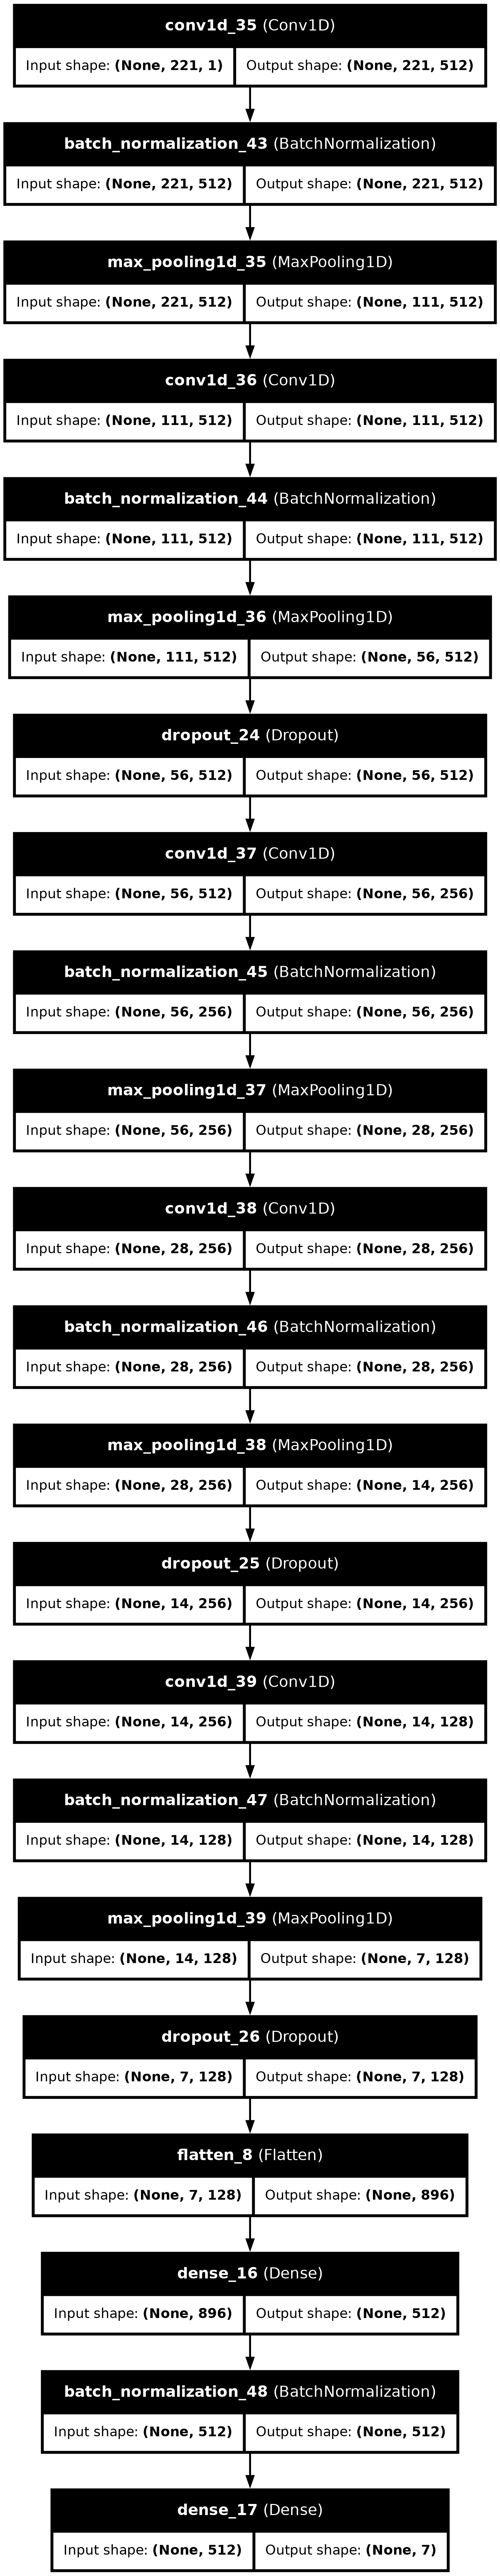

In [116]:
saved_model_path = '/kaggle/working/model_main2.json'
saved_weights_path = '/kaggle/working/best_model2.weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()
    
# Loading the model architecture, weights
model2 = tf.keras.models.model_from_json(json_savedModel)
model2.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='sparse_categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model2, to_file='model2.png', show_shapes=True, show_layer_names=True)